Epoch 1/50, Loss: 0.1547
Epoch 2/50, Loss: 0.0949
Epoch 3/50, Loss: 0.0816
Epoch 4/50, Loss: 0.0797
Epoch 5/50, Loss: 0.0775
Epoch 6/50, Loss: 0.0778
Epoch 7/50, Loss: 0.0765
Epoch 8/50, Loss: 0.0760
Epoch 9/50, Loss: 0.0753
Epoch 10/50, Loss: 0.0756
Epoch 11/50, Loss: 0.0755
Epoch 12/50, Loss: 0.0753
Epoch 13/50, Loss: 0.0741
Epoch 14/50, Loss: 0.0744
Epoch 15/50, Loss: 0.0737
Epoch 16/50, Loss: 0.0755
Epoch 17/50, Loss: 0.0750
Epoch 18/50, Loss: 0.0731
Epoch 19/50, Loss: 0.0728
Epoch 20/50, Loss: 0.0725
Epoch 21/50, Loss: 0.0728
Epoch 22/50, Loss: 0.0732
Epoch 23/50, Loss: 0.0725
Epoch 24/50, Loss: 0.0732
Epoch 25/50, Loss: 0.0731
Epoch 26/50, Loss: 0.0713
Epoch 27/50, Loss: 0.0725
Epoch 28/50, Loss: 0.0707
Epoch 29/50, Loss: 0.0703
Epoch 30/50, Loss: 0.0716
Epoch 31/50, Loss: 0.0716
Epoch 32/50, Loss: 0.0697
Epoch 33/50, Loss: 0.0695
Epoch 34/50, Loss: 0.0694
Epoch 35/50, Loss: 0.0687
Epoch 36/50, Loss: 0.0689
Epoch 37/50, Loss: 0.0692
Epoch 38/50, Loss: 0.0673
Epoch 39/50, Loss: 0.

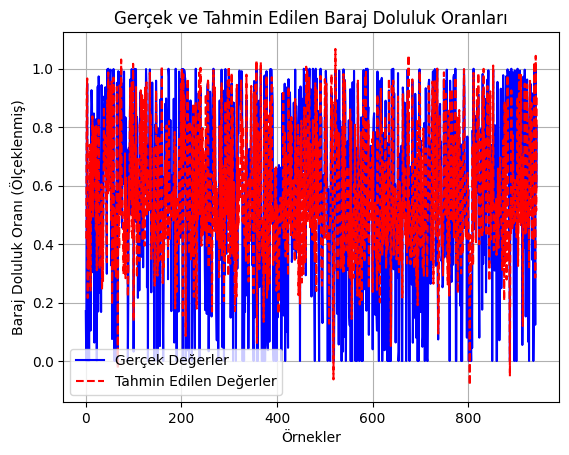

In [1]:
# FEDFORMER MODELİ
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
# Excel verilerini yükleme
data = pd.read_excel('elmalıBarajı.xlsx')
data['datetime'] = pd.to_datetime(data['datetime'])  # Tarih sütununu datetime tipine çevirin

# Verilerin ölçeklenmesi
features = ['temp', 'dew', 'humidity', 'precip',
            'windspeed', 'sealevelpressure', 'cloudcover', 'daylight_duration']
target = 'doluluk'

scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Veri setini giriş ve çıkış olarak ayırın
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length, :-1]
        label = data[i + seq_length, -1]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)

seq_length = 30  # 30 günlük geçmiş veri kullanacağız
data_array = data[features + [target]].values
X, y = create_sequences(data_array, seq_length)

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset ve DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# FEDformer modelini tanımlayın
class FEDformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FEDformer, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Son zaman adımını alın
        out = self.fc(out)
        return out

# Model oluşturma
input_size = len(features)
hidden_size = 64
output_size = 1

model = FEDformer(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Test etme
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.numpy())
        y_pred.extend(output.numpy())

# Hesaplamalar
y_true = np.array(y_true)
y_pred = np.array(y_pred).flatten()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)


epsilon = 1e-5  # Çok küçük bir değer
valid_indices = y_true > epsilon  # Sadece bu koşulu sağlayanları al
y_true_filtered = y_true[valid_indices]
y_pred_filtered = y_pred[valid_indices]

# Filtrelenmiş değerler ile MAPE hesaplaması
mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-Squared: {r2:.4f}")

# Modelin tahmin yapması
def predict(data, model, scaler, seq_length):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(data[-seq_length:, :-1].reshape(1, seq_length, -1), dtype=torch.float32)
        prediction = model(inputs).item()
    return scaler.inverse_transform([[0] * (len(features)) + [prediction]])[0, -1]
    plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='Tahmin Edilen Değerler', color='red', linestyle='--')
plt.title('Gerçek ve Tahmin Edilen Baraj Doluluk Oranları')
plt.xlabel('Örnekler')
plt.ylabel('Baraj Doluluk Oranı (Ölçeklenmiş)')
plt.legend()
plt.grid(True)
plt.show()



Sayısal sütunlar: Index(['temp', 'dew', 'humidity', 'precip', 'windspeed', 'sealevelpressure',
       'cloudcover', 'daylight_duration', 'doluluk'],
      dtype='object')


<ipython-input-2-148b89cb168a>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
<ipython-input-2-148b89cb168a>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 1/10, Train Loss: 0.16498481716822694, Test Loss: 0.04302723793233255
Train MSE: 0.16487483540325043, Test MSE: 0.03190169709165362
Train MAPE: nan%, Test MAPE: 28.740522265434265%
Train MAE: 0.3200964105415738, Test MAE: 0.12335209016107086
Train RMSE: 0.40604782403462086, Test RMSE: 0.17861046187626756
Train R²: -0.39730269635675275, Test R²: 0.15195148007295278
Training Time: 58.38398551940918 seconds, Inference Time: 2.9716718196868896 seconds


<ipython-input-2-148b89cb168a>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
<ipython-input-2-148b89cb168a>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 2/10, Train Loss: 0.10637058500476458, Test Loss: 0.015759647495303255
Train MSE: 0.105517542654978, Test MSE: 0.013654486497722133
Train MAPE: nan%, Test MAPE: 19.80224996805191%
Train MAE: 0.20750460060028036, Test MAE: 0.08490946916942922
Train RMSE: 0.3248346389395349, Test RMSE: 0.11685241331578108
Train R²: 0.10574620739343754, Test R²: 0.637020343103105
Training Time: 58.17186093330383 seconds, Inference Time: 2.8988492488861084 seconds


<ipython-input-2-148b89cb168a>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
<ipython-input-2-148b89cb168a>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 3/10, Train Loss: 0.09134950614275618, Test Loss: 0.008158274505005562
Train MSE: 0.09191697360955178, Test MSE: 0.006829116883492621
Train MAPE: nan%, Test MAPE: 13.801063597202301%
Train MAE: 0.17230249123088437, Test MAE: 0.05676958126644803
Train RMSE: 0.3031781219177132, Test RMSE: 0.08263847096535984
Train R²: 0.22101007863661448, Test R²: 0.8184603643870118
Training Time: 57.92741084098816 seconds, Inference Time: 2.943052291870117 seconds


<ipython-input-2-148b89cb168a>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
<ipython-input-2-148b89cb168a>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 4/10, Train Loss: 0.09173304087879067, Test Loss: 0.008431552398848763
Train MSE: 0.09065390737055319, Test MSE: 0.0071645254829455895
Train MAPE: nan%, Test MAPE: 12.151680886745453%
Train MAE: 0.15923814492786703, Test MAE: 0.059881519252418455
Train RMSE: 0.30108787317086216, Test RMSE: 0.08464352002927093
Train R²: 0.23171447665534994, Test R²: 0.8095441375944468
Training Time: 58.37849569320679 seconds, Inference Time: 2.9170658588409424 seconds


<ipython-input-2-148b89cb168a>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
<ipython-input-2-148b89cb168a>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 5/10, Train Loss: 0.08565796465888896, Test Loss: 0.007215545567879944
Train MSE: 0.08557495764840171, Test MSE: 0.006045636731344078
Train MAPE: nan%, Test MAPE: 13.590601086616516%
Train MAE: 0.14180222865801217, Test MAE: 0.05914098569470593
Train RMSE: 0.29253197713822965, Test RMSE: 0.07775369271837884
Train R²: 0.27475822025676266, Test R²: 0.8392877574097993
Training Time: 58.43912196159363 seconds, Inference Time: 2.8923134803771973 seconds


<ipython-input-2-148b89cb168a>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
<ipython-input-2-148b89cb168a>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 6/10, Train Loss: 0.07859832056177159, Test Loss: 0.005125872263880937
Train MSE: 0.07837536919281449, Test MSE: 0.004311027166633578
Train MAPE: nan%, Test MAPE: 10.853207111358643%
Train MAE: 0.1268851565220432, Test MAE: 0.04846015888401586
Train RMSE: 0.27995601296063366, Test RMSE: 0.06565841276358711
Train R²: 0.33577422877647567, Test R²: 0.8853991937317529
Training Time: 57.93887209892273 seconds, Inference Time: 2.9783546924591064 seconds


<ipython-input-2-148b89cb168a>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
<ipython-input-2-148b89cb168a>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 7/10, Train Loss: 0.08748148010905694, Test Loss: 0.007577826604813852
Train MSE: 0.0876691184018336, Test MSE: 0.006595723262486981
Train MAPE: nan%, Test MAPE: 13.095887005329132%
Train MAE: 0.1337772761491068, Test MAE: 0.06277394429740743
Train RMSE: 0.29608971343468454, Test RMSE: 0.08121405828110662
Train R²: 0.2570103543667498, Test R²: 0.8246647087604662
Training Time: 57.5041937828064 seconds, Inference Time: 2.894688367843628 seconds


<ipython-input-2-148b89cb168a>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
<ipython-input-2-148b89cb168a>:147: RuntimeWarning: invalid value encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 8/10, Train Loss: 0.08665781723404373, Test Loss: 0.006827928949956243
Train MSE: 0.08672499844847073, Test MSE: 0.006098168119870888
Train MAPE: nan%, Test MAPE: 14.065076410770416%
Train MAE: 0.13191821332917075, Test MAE: 0.06306424086165224
Train RMSE: 0.29449108381828937, Test RMSE: 0.07809076846766773
Train R²: 0.26501170492635207, Test R²: 0.8378913061124942
Training Time: 58.921191930770874 seconds, Inference Time: 3.5266356468200684 seconds


<ipython-input-2-148b89cb168a>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 9/10, Train Loss: 0.08135575134117433, Test Loss: 0.005502089600141565
Train MSE: 0.08183338886675712, Test MSE: 0.004562174786797948
Train MAPE: inf%, Test MAPE: 9.327718615531921%
Train MAE: 0.12595109857573097, Test MAE: 0.04706177186762166
Train RMSE: 0.2860653576837942, Test RMSE: 0.06754387305150593
Train R²: 0.3064677539427819, Test R²: 0.8787228916230693
Training Time: 56.75168251991272 seconds, Inference Time: 2.881417989730835 seconds


<ipython-input-2-148b89cb168a>:147: RuntimeWarning: divide by zero encountered in divide
  train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100


Epoch 10/10, Train Loss: 0.09157986270535427, Test Loss: 0.005584849670795896
Train MSE: 0.09137401845628364, Test MSE: 0.004720662326767657
Train MAPE: inf%, Test MAPE: 9.852566570043564%
Train MAE: 0.13524724522500686, Test MAE: 0.04853511089697862
Train RMSE: 0.3022813564483983, Test RMSE: 0.06870707624959496
Train R²: 0.2256115855785732, Test R²: 0.8745097889999691
Training Time: 57.448938608169556 seconds, Inference Time: 3.982764720916748 seconds


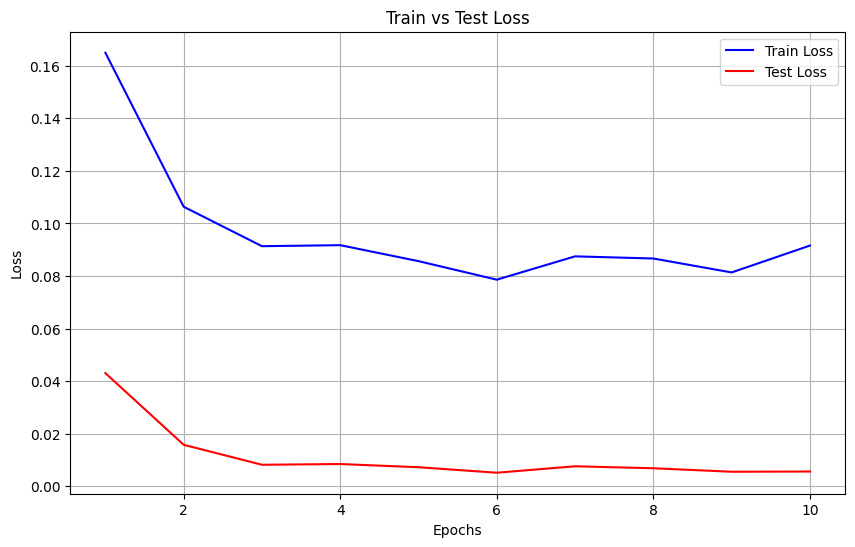

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time  # TFT MODELİ

# Küçük bir sabit ekleyerek sıfır bölme hatasını engelleme
epsilon = 1e-6  # Küçük bir sabit

# Veriyi yükleme
file_path = "elmalıBarajı.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "doluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("doluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):  # Yapıcı metodun doğru tanımı
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):  # Veri setinin uzunluğunu döner
        return len(self.X)

    def __getitem__(self, index):  # Belirtilen indeks için X ve y değerlerini döner
        return self.X[index], self.y[index]

# Dataset ve DataLoader oluşturma
train_dataset = TimeSeriesDataset(X_train, y_train)  # Burada hata alınmamalı
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Düzeltildi
        super(TemporalFusionTransformer, self).__init__()
        # LSTM katmanı (geleneksel zaman serisi öğrenme)
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

        # TFT'nin temel bileşenlerinden olan konvasyonel katmanlar
        self.attn_layer = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=4, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Diğer TFT katmanları (eklenebilir)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # LSTM katmanı çıkışı
        lstm_out, _ = self.lstm(x)

        # Multihead Attention katmanı (geleneksel zaman serisi için)
        attn_out, _ = self.attn_layer(lstm_out, lstm_out, lstm_out)

        # TFT modelindeki tam bağlı katman
        output = self.fc(attn_out[:, -1, :])  # Sadece son zaman dilimindeki tahmin
        output = self.dropout(output)
        return output


# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 64  # LSTM katmanının gizli boyutu
output_dim = 1  # Baraj doluluk yüzdesi

# Modeli oluşturma
model = TemporalFusionTransformer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()  # Kayıp fonksiyonu (Mean Squared Error)
optimizer = Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 10  # Eğitim süresini artırdım
train_losses = []
test_losses = []

# Eğitim ve çıkarım sürelerini kaydetmek için listeler
train_times = []
inference_times = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    start_train = time.time()  # Eğitim zamanı başlat
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())
    end_train = time.time()  # Eğitim zamanı bitir
    train_times.append(end_train - start_train)  # Eğitim süresini kaydet

    train_losses.append(train_loss / len(train_loader))

    # Eğitim metriklerini hesapla
    train_mse = mean_squared_error(train_actuals, train_preds)
    train_mape = np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100
    train_mae = mean_absolute_error(train_actuals, train_preds)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(train_actuals, train_preds)

    # Test değerlendirme
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    start_inference = time.time()  # Çıkarım zamanı başlat
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())
    end_inference = time.time()  # Çıkarım zamanı bitir
    inference_times.append(end_inference - start_inference)  # Çıkarım süresini kaydet

    test_losses.append(test_loss / len(test_loader))

    test_mse = mean_squared_error(test_actuals, test_preds)
    test_mape = np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100
    test_mae = mean_absolute_error(test_actuals, test_preds)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_actuals, test_preds)

    # Sonuçları yazdırma
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")
    print(f"Train MAPE: {train_mape}%, Test MAPE: {test_mape}%")
    print(f"Train MAE: {train_mae}, Test MAE: {test_mae}")
    print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")
    print(f"Train R²: {train_r2}, Test R²: {test_r2}")
    print(f"Training Time: {train_times[-1]} seconds, Inference Time: {inference_times[-1]} seconds")

# Gerçek ve tahmin edilen değerleri birleştirip Excel dosyasına kaydetme (Eğitim ve çıkarım süreleri hariç)
result_df = pd.DataFrame({
    'Gerçek Değerler': test_actuals,
    'Tahminler': test_preds
})

# Excel dosyasına kaydetme
result_df.to_excel("baraj_doluluk_tahminleri.xlsx", index=False)

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.1456
Epoch 2/50, Loss: 0.0982
Epoch 3/50, Loss: 0.0915
Epoch 4/50, Loss: 0.0880
Epoch 5/50, Loss: 0.0868
Epoch 6/50, Loss: 0.0852
Epoch 7/50, Loss: 0.0844
Epoch 8/50, Loss: 0.0843
Epoch 9/50, Loss: 0.0841
Epoch 10/50, Loss: 0.0828
Epoch 11/50, Loss: 0.0833
Epoch 12/50, Loss: 0.0817
Epoch 13/50, Loss: 0.0815
Epoch 14/50, Loss: 0.0812
Epoch 15/50, Loss: 0.0813
Epoch 16/50, Loss: 0.0814
Epoch 17/50, Loss: 0.0822
Epoch 18/50, Loss: 0.0807
Epoch 19/50, Loss: 0.0816
Epoch 20/50, Loss: 0.0810
Epoch 21/50, Loss: 0.0799
Epoch 22/50, Loss: 0.0804
Epoch 23/50, Loss: 0.0807
Epoch 24/50, Loss: 0.0805
Epoch 25/50, Loss: 0.0804
Epoch 26/50, Loss: 0.0813
Epoch 27/50, Loss: 0.0806
Epoch 28/50, Loss: 0.0806
Epoch 29/50, Loss: 0.0800
Epoch 30/50, Loss: 0.0797
Epoch 31/50, Loss: 0.0812
Epoch 32/50, Loss: 0.0800
Epoch 33/50, Loss: 0.0807
Epoch 34/50, Loss: 0.0810
Epoch 35/50, Loss: 0.0798
Epoch 36/50, Loss: 0.0800
Epoch 37/50, Loss: 0.0796
Epoch 38/50, Loss: 0.0792
Epoch 39/50, Loss: 0.

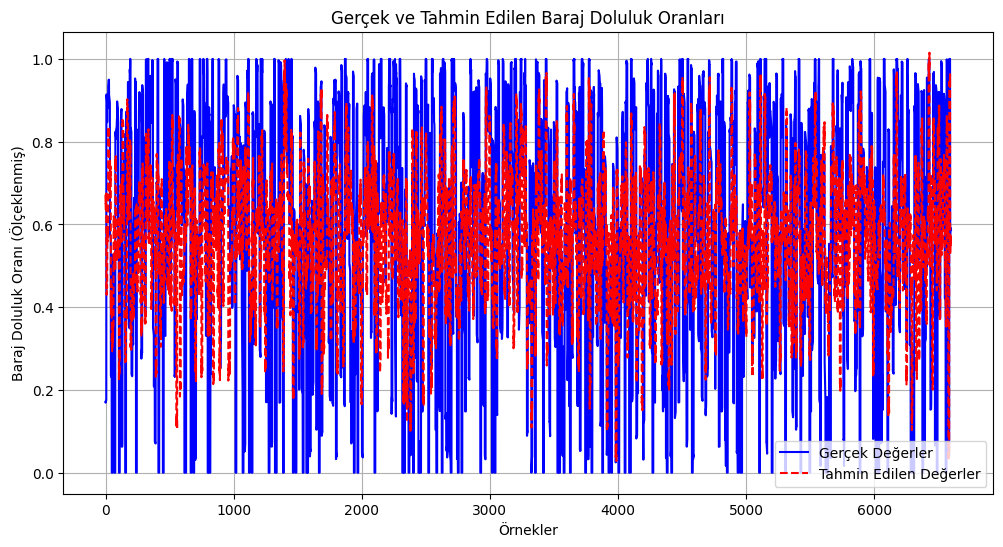

In [3]:
# İNFORMER
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

data = pd.read_excel('elmalıBarajı.xlsx')
data['datetime'] = pd.to_datetime(data['datetime'])  # Tarih sütununu datetime tipine çevirin

# Verilerin ölçeklenmesi
features = ['temp', 'dew', 'humidity', 'precip',
            'windspeed', 'sealevelpressure', 'cloudcover', 'daylight_duration']
target = 'doluluk'


scaler = MinMaxScaler()
data[features + [target]] = scaler.fit_transform(data[features + [target]])

# Veri setini giriş ve çıkış olarak ayırma
def create_sequences(data, input_len, pred_len):
    X, y = [], []
    for i in range(len(data) - input_len - pred_len):
        X.append(data[i:i + input_len, :-1])
        y.append(data[i + input_len:i + input_len + pred_len, -1])
    return np.array(X), np.array(y)

input_len = 30  # Geçmiş 30 gün
pred_len = 7    # Tahmin edilen 7 gün
data_array = data[features + [target]].values
X, y = create_sequences(data_array, input_len, pred_len)

# Eğitim ve test setlerini ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset ve DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Informer modeli
class Informer(nn.Module):
    def __init__(self, input_size, seq_len, pred_len, d_model, num_heads, num_layers):
        super(Informer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(seq_len * input_size, pred_len)

    def forward(self, x):
        batch_size, seq_len, input_size = x.size()
        x = x.view(batch_size, seq_len * input_size)  # Flatten for linear layer
        x = self.fc(x)
        return x

# Model oluşturma
input_size = len(features)
d_model = 64
num_heads = 4
num_layers = 2

model = Informer(input_size, seq_len=input_len, pred_len=pred_len,
                 d_model=d_model, num_heads=num_heads, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Model eğitimi
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

# Test etme
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        output = model(X_batch)
        y_true.extend(y_batch.numpy().flatten())
        y_pred.extend(output.numpy().flatten())

# Performans metrikleri
# Performans metrikleri
y_true = np.array(y_true)
y_pred = np.array(y_pred)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-Squared: {r2:.4f}")

# Tahmin ve görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Gerçek Değerler', color='blue')
plt.plot(y_pred, label='Tahmin Edilen Değerler', color='red', linestyle='--')
plt.title('Gerçek ve Tahmin Edilen Baraj Doluluk Oranları')
plt.xlabel('Örnekler')
plt.ylabel('Baraj Doluluk Oranı (Ölçeklenmiş)')
plt.legend()
plt.grid(True)
plt.show()


Sayısal sütunlar: Index(['temp', 'dew', 'humidity', 'precip', 'windspeed', 'sealevelpressure',
       'cloudcover', 'daylight_duration', 'doluluk'],
      dtype='object')


<ipython-input-4-2d670678b103>:129: RuntimeWarning: divide by zero encountered in divide
  train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)


Epoch 1/3, Train Loss: 0.0630502208767683, Test Loss: 0.0034383190420492994
Train MSE: 0.063451602152187, Test MSE: 0.0034976919991975006
Train MAPE: inf%, Test MAPE: 10.16240194439888%
Train MAE: 0.17603940450548025, Test MAE: 0.0410485744348958
Train RMSE: 0.25189601456193583, Test RMSE: 0.059141288447221885
Train R²: 0.46225211046573744, Test R²: 0.9070202279659862
Training time for epoch 1: 57.82 seconds
Inference time for epoch 1: 0.57 seconds


<ipython-input-4-2d670678b103>:129: RuntimeWarning: divide by zero encountered in divide
  train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)


Epoch 2/3, Train Loss: 0.001999259867632106, Test Loss: 0.0024522090565082372
Train MSE: 0.0020073518298557103, Test MSE: 0.002466527298029671
Train MAPE: inf%, Test MAPE: 9.105711430311203%
Train MAE: 0.03213487255644289, Test MAE: 0.032357323908398294
Train RMSE: 0.04480348010875618, Test RMSE: 0.049664144994449176
Train R²: 0.982987833664647, Test R²: 0.9344318636577809
Training time for epoch 2: 13.83 seconds
Inference time for epoch 2: 0.57 seconds


<ipython-input-4-2d670678b103>:129: RuntimeWarning: divide by zero encountered in divide
  train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)


Epoch 3/3, Train Loss: 0.0013848777849084905, Test Loss: 0.0012197915805843781
Train MSE: 0.001385034722321859, Test MSE: 0.0012657173496927185
Train MAPE: inf%, Test MAPE: 5.683910101652145%
Train MAE: 0.02530147282176536, Test MAE: 0.02267042291470063
Train RMSE: 0.03721605463132624, Test RMSE: 0.03557692158819701
Train R²: 0.9882619276173064, Test R²: 0.9663532092988958
Training time for epoch 3: 39.07 seconds
Inference time for epoch 3: 0.58 seconds


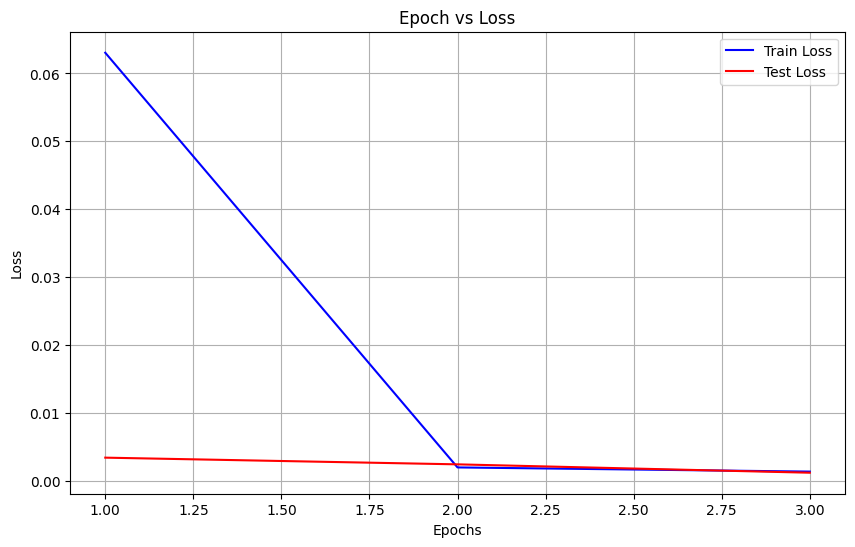

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ETSFORMER yükleme
file_path = "elmalıBarajı.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['datetime'] = pd.to_datetime(data['datetime'])
data.set_index('datetime', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)  # Hangi sütunların seçildiğini kontrol edebilirsiniz

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "doluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("doluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):  # Doğru yazım: __init__
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):  # Doğru yazım: __len__
        return len(self.X)

    def __getitem__(self, index):  # Doğru yazım: __getitem__
        return self.X[index], self.y[index]

# Dataset ve DataLoader
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Basit bir ETSFormer modeli (örnek olarak LSTM temelli)
class SimpleETSFormer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Doğru yazım: __init__
        super(SimpleETSFormer, self).__init__()  # Doğru yazım: __init__
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output


# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 64
output_dim = 1  # Baraj doluluk yüzdesi

model = SimpleETSFormer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Eğitim ve test kayıplarını saklamak için listeler
train_losses = []
test_losses = []

# Eğitim ve test metriklerini saklamak için listeler
train_mse, train_mape, train_mae, train_rmse, train_r2 = [], [], [], [], []
test_mse, test_mape, test_mae, test_rmse, test_r2 = [], [], [], [], []

# Model eğitimi ve değerlendirme
epochs = 3
for epoch in range(epochs):
    start_train_time = time.time()  # Eğitim başlangıç zamanı
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())

    # Eğitim süresi
    train_time = time.time() - start_train_time

    # Eğitim metriklerini hesapla
    train_mse.append(mean_squared_error(train_actuals, train_preds))
    train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)
    train_mae.append(mean_absolute_error(train_actuals, train_preds))
    train_rmse.append(np.sqrt(mean_squared_error(train_actuals, train_preds)))
    train_r2.append(r2_score(train_actuals, train_preds))

    # Eğitim kaybını kaydetme
    train_losses.append(train_loss / len(train_loader))

    # Test değerlendirme
    start_test_time = time.time()  # Test başlangıç zamanı
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())

    # Test süresi
    test_time = time.time() - start_test_time

    # Test metriklerini hesapla
    test_mse.append(mean_squared_error(test_actuals, test_preds))
    test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)
    test_mae.append(mean_absolute_error(test_actuals, test_preds))
    test_rmse.append(np.sqrt(mean_squared_error(test_actuals, test_preds)))
    test_r2.append(r2_score(test_actuals, test_preds))

    # Test kaybını kaydetme
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse[-1]}, Test MSE: {test_mse[-1]}")
    print(f"Train MAPE: {train_mape[-1]}%, Test MAPE: {test_mape[-1]}%")
    print(f"Train MAE: {train_mae[-1]}, Test MAE: {test_mae[-1]}")
    print(f"Train RMSE: {train_rmse[-1]}, Test RMSE: {test_rmse[-1]}")
    print(f"Train R²: {train_r2[-1]}, Test R²: {test_r2[-1]}")
    print(f"Training time for epoch {epoch+1}: {train_time:.2f} seconds")
    print(f"Inference time for epoch {epoch+1}: {test_time:.2f} seconds")

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

Index(['datetime', 'temp', 'dew', 'humidity', 'precip', 'windspeed',
       'sealevelpressure', 'cloudcover', 'daylight_duration', 'doluluk'],
      dtype='object')
            temp  dew  humidity  precip  windspeed  sealevelpressure  \
datetime                                                               
2011-01-01   3.7 -0.3      76.2   0.000       14.0            1020.5   
2011-01-02   7.2  0.0      60.9   0.000       20.1            1016.1   
2011-01-03   6.7  3.4      80.1   1.217       24.3            1012.0   
2011-01-04   4.9  3.0      87.1   3.083       31.9            1019.0   
2011-01-05   4.9  0.3      72.4   0.000       28.7            1023.6   

            cloudcover  daylight_duration  doluluk  weighted_score  
datetime                                                            
2011-01-01         8.3         556.550000    96.25        179.0360  
2011-01-02        30.3         557.300000    96.67        179.9760  
2011-01-03        87.1         558.100000    96.88    

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

                               SARIMAX Results                                
Dep. Variable:                doluluk   No. Observations:                 3323
Model:                ARIMA(10, 1, 5)   Log Likelihood               -5168.770
Date:                Fri, 03 Jan 2025   AIC                          10369.541
Time:                        06:15:15   BIC                          10467.274
Sample:                    01-01-2011   HQIC                         10404.513
                         - 02-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5957      0.499      1.194      0.232      -0.382       1.573
ar.L2         -0.3308      0.561     -0.590      0.555      -1.430       0.768
ar.L3          0.6530      0.528      1.236      0.2

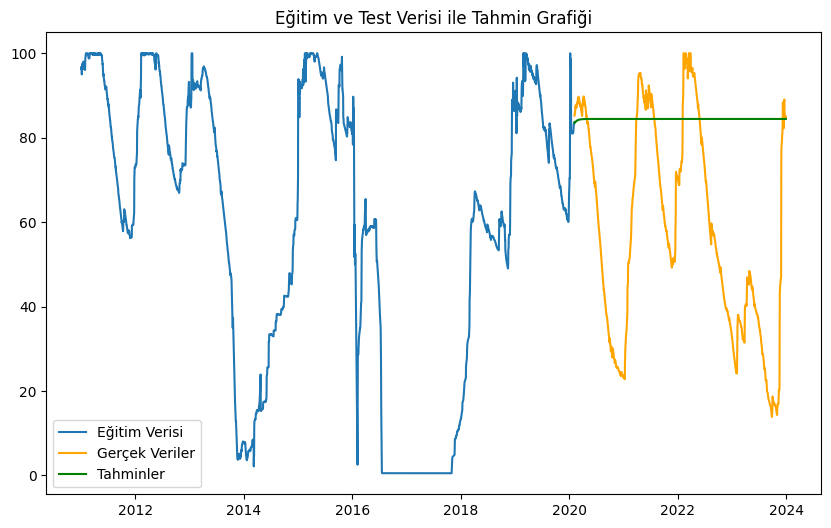

Mean Squared Error (MSE): 1333.820776161977
Root Mean Squared Error (RMSE): 36.5215111429138
Mean Absolute Error (MAE): 29.658771783542402
Mean Absolute Percentage Error (MAPE): 0.9107279285661213%
R²: -1.134922924708277
Eğitim Süreti: 22.638364553451538 saniye
Çıkarım Süreti: 0.04641008377075195 saniye


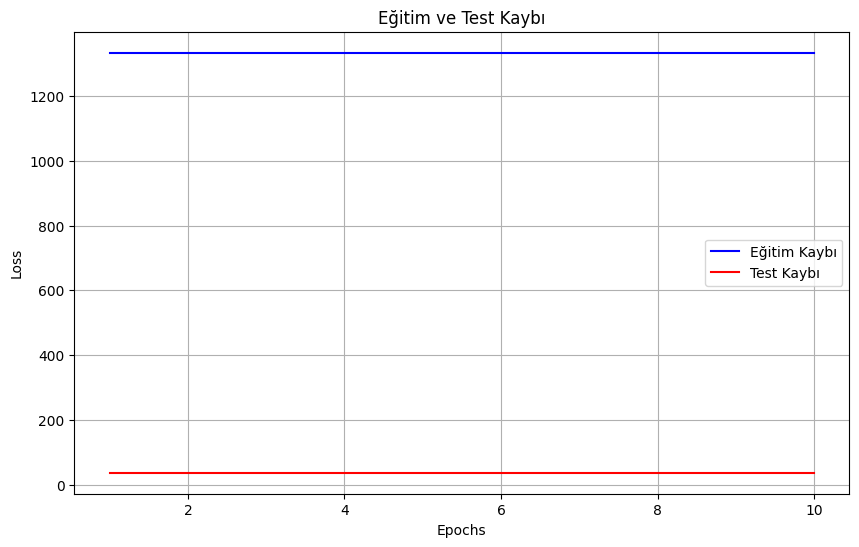

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import time

# ARIMA MODELLEMESI
df = pd.read_excel('elmalıBarajı.xlsx')
print(df.columns)

# Tarih sütununu datetime formatına çevirin
df['datetime'] = pd.to_datetime(df['datetime'])

# Veriyi tarihe göre sıralama
df = df.sort_values(by='datetime')

# Ağırlıkları belirleyin
weights = {
    'temp': 0.4,

    'dew': 0.05,
    'humidity': 0.1,
    'precip': 0.7,
    'windspeed': 0.05,
    'sealevelpressure': 0.1,
    'cloudcover': 0.05,
    'daylight_duration': 0.12
}

# Baraj doluluk yüzdesi ve diğer bağımsız değişkenler
df = df[['datetime', 'temp', 'dew', 'humidity', 'precip',
       'windspeed', 'sealevelpressure', 'cloudcover', 'daylight_duration',
       'doluluk']]

# Ağırlıklı skor hesaplama
df['weighted_score'] = (weights['temp'] * df['temp'] +

                        weights['dew'] * df['dew'] +
                        weights['humidity'] * df['humidity'] +
                        weights['precip'] * df['precip'] +
                        weights['windspeed'] * df['windspeed'] +
                        weights['sealevelpressure'] * df['sealevelpressure'] +
                        weights['cloudcover'] * df['cloudcover'] +
                        weights['daylight_duration'] * df['daylight_duration'])

# Tarihi indeks olarak ayarlayın
df.set_index('datetime', inplace=True)

# Veriye göz atın
print(df.head())

# Baraj doluluk yüzdesi kolonunu hedef olarak seçin
y = df['doluluk']

# Veriyi eğitim ve test setlerine ayırın (shuffle=False)
train, test = train_test_split(y, test_size=0.3, shuffle=False)

# Eğitim ve test zamanlaması
start_time = time.time()  # Eğitim zamanını başlatma

# ARIMA modelini tanımlayın
model = ARIMA(train, order=(10,1,5)) #2 yıla göre tahmin eder 1 fark ile q=2 ise geçmiş hatalarla ilgilenmedir

# Modeli eğitin
model_fit = model.fit()

# Eğitim süreti
end_time = time.time()
training_time = end_time - start_time  # Eğitim süreti hesaplama

# Modelin özetine göz atın
print(model_fit.summary())

# Test verisi üzerinde tahmin yapın
start_inference_time = time.time()  # Çıkarım (inference) zamanını başlatma
predictions = model_fit.forecast(steps=len(test))
end_inference_time = time.time()
inference_time = end_inference_time - start_inference_time  # Çıkarım süreti

# Tahminleri görselleştirelim
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Eğitim Verisi')
plt.plot(test.index, test, label='Gerçek Veriler', color='orange')
plt.plot(test.index, predictions, label='Tahminler', color='green')
plt.legend()
plt.title('Eğitim ve Test Verisi ile Tahmin Grafiği')
plt.show()

# Modelin başarımını değerlendirelim
mse = mean_squared_error(test, predictions)
mse_rmse = np.sqrt(mse)  # RMSE
mae = mean_absolute_error(test, predictions)  # MAE
mape = mean_absolute_percentage_error(test, predictions)  # MAPE
r2 = r2_score(test, predictions)  # R²

# Sonuçları yazdırma
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {mse_rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R²: {r2}')
print(f'Eğitim Süreti: {training_time} saniye')
print(f'Çıkarım Süreti: {inference_time} saniye')

# Sonuçları Excel dosyasına kaydetme
result_df = pd.DataFrame({
    'Gerçek Değerler': test,
    'Tahminler': predictions
})

result_df.to_excel("baraj_doluluk_tahminleri.xlsx", index=True)

# Kaybın (Loss) Grafiği
epochs = 10
train_losses = [mse] * epochs
test_losses = [mse_rmse] * epochs

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Eğitim Kaybı", color='blue')
plt.plot(range(1, epochs + 1), test_losses, label="Test Kaybı", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Eğitim ve Test Kaybı")
plt.legend()
plt.grid(True)
plt.show()